In [151]:
%load_ext lab_black

<IPython.core.display.Javascript object>

In [266]:
from pathlib import Path
from typing import Union, Dict, Optional, List
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from camelsml.metrics import calc_nse
from camelsml.datautils import load_attributes
from camelsml import load_config
from camelsml.utils import get_basin_list
import scipy.cluster as spc

<IPython.core.display.Javascript object>

# This notebook contains results from our attempt at reducing static features.

In [241]:
def correlation(
    attributes: pd.DataFrame, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    corr = attributes.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.7747, 4.7747))
    ax.tick_params(axis="both", which="both", labelsize=5)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.1,
        cbar_kws={"shrink": 0.5},
        ax=ax,
    )
    ax.xaxis.label.set_size(5)
    ax.yaxis.label.set_size(0)
    if title is not None:
        ax.set_title(title)

<IPython.core.display.Javascript object>

In [343]:
def dendrogram(
    attributes: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
) -> np.ndarray:
    # Using the absolute value Pearson correlations.
    corr = attributes.corr().abs()
    corr_linkage = spc.hierarchy.ward(corr)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    dendro = spc.hierarchy.dendrogram(
        corr_linkage, ax=ax, orientation="left", labels=attributes.columns
    )
    return corr_linkage


def feature_reduction(
    corr_linkage: np.ndarray, level: int, labels: np.ndarray
) -> np.ndarray:
    cluster_ids = spc.hierarchy.fcluster(corr_linkage, level, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return labels[selected_features]

<IPython.core.display.Javascript object>

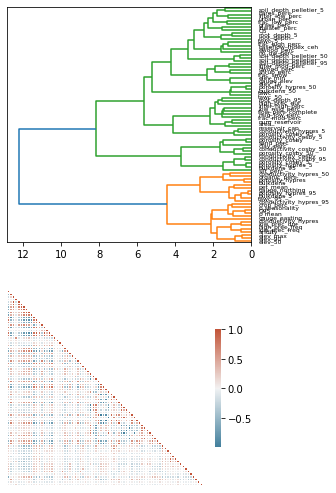

<IPython.core.display.Javascript object>

In [299]:
cfg = load_config("../runs/correlation_reduction/all_features/run_config.txt")
db_path = "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204/attributes.db"
basins = get_basin_list(cfg["train_basin_file"])
attributes = load_attributes(
    db_path=db_path,
    basins=basins,
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))  # 8.27615))
axes = axes.flatten()
correlation(attributes, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
corr_linkage = dendrogram(attributes, ax=axes[0])
# axes[0].set_yticks([])
# axes[0].set_xticks([])
fig.tight_layout()
fig.savefig(
    "../doc/thesis/figures/correlation_reduction/all_features/corr_and_dendrogram.pdf"
)

In [68]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    for epoch in range(1, epochs+1):
        with open(folder / f"{model_type}_seed{seed}_epoch_{epoch}.p",
                  "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(obs=results[basin]["qobs"].to_numpy(), sim=results[basin]["qsim"].to_numpy())
    return nse_values

<IPython.core.display.Javascript object>

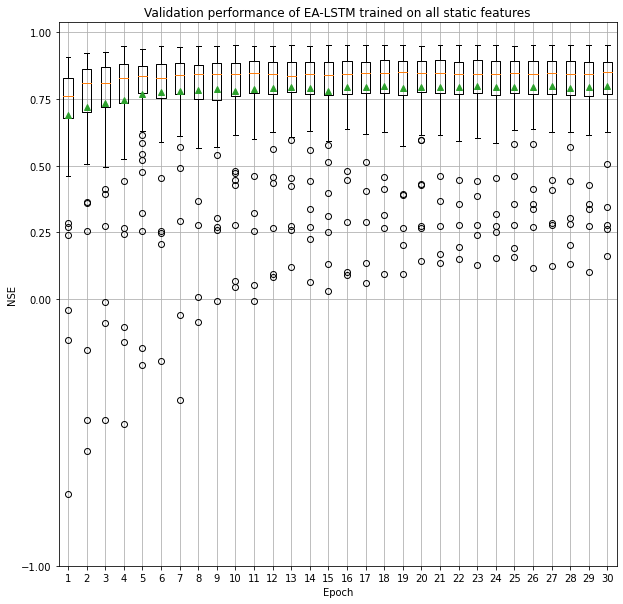

[0.69017784 0.72054877 0.73604675 0.74761094 0.76849673 0.77611837
 0.78045017 0.78284605 0.78763358 0.78113335 0.78902307 0.7903965
 0.79360349 0.79081544 0.78129188 0.79582762 0.79424926 0.79897091
 0.79199456 0.79559274 0.79630573 0.7941257  0.79721019 0.79466446
 0.79419932 0.79570323 0.79784832 0.79169588 0.7952988  0.79739304]
[0.264656   0.28000996 0.24285915 0.25628448 0.21859661 0.1968267
 0.20911361 0.18710766 0.17363289 0.18382675 0.18730733 0.17407244
 0.16412872 0.17231567 0.18568645 0.16866735 0.1725669  0.16262387
 0.17254964 0.16346465 0.16971724 0.16780767 0.16519484 0.16633242
 0.16788469 0.16423722 0.16178933 0.17068161 0.1645474  0.16148538]
[0.7625028  0.80994273 0.80907494 0.8296039  0.83753585 0.82990868
 0.83962137 0.84427258 0.84454259 0.8417943  0.84623674 0.84527404
 0.83723677 0.84265324 0.83952961 0.84511672 0.84631964 0.84838817
 0.8506411  0.84791684 0.8488717  0.84341415 0.84345028 0.84350772
 0.84604085 0.84438516 0.84734576 0.84255673 0.8440514  0.8505

<IPython.core.display.Javascript object>

In [363]:
results_full_features = load_results(
    "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204",
    "ealstm",
    19970204,
)
results = []
for i, epoch in enumerate(results_full_features.keys()):
    results.append(np.array(list(results_full_features[epoch].values())))
results = np.array(results).T
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.boxplot(results, showmeans=True)
ax.set_xlabel("Epoch")
ax.set_ylabel("NSE")
ax.grid()
ax.set_yticks([-1, 0, 0.25, 0.5, 0.75, 1])
ax.set_title("Validation performance of EA-LSTM trained on all static features")
plt.show()
print(results.mean(axis=0))
print(results.std(axis=0))
print(np.median(results, axis=0))

## Removing 20 features by setting the treshold to 9.3

This will be used to train a new model

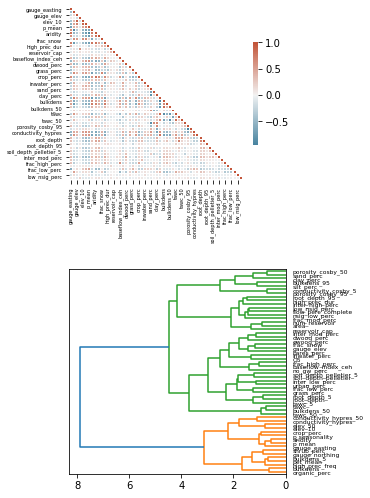

<IPython.core.display.Javascript object>

In [351]:
keep = feature_reduction(corr_linkage, level=0.93, labels=attributes.columns.to_numpy())
np.savetxt(
    "../runs/correlation_reduction/20_less_features/use_features.txt", keep, fmt="%s"
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes.flatten()
reduced_attributes_20 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_20, ax=axes[0])
dendrogram(reduced_attributes_20, ax=axes[1])
fig.tight_layout()